In [82]:
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [84]:
def plot_n_images(df, n):
    for i in range(0,n):
        jpg_path=f"Orinoquia_Carma_Traps/orinoquia_camera_traps_images/public/{df.file_name[i]}"
        img = Image.open(jpg_path)
        # Plot it
        print(i)
        print(df.has_animal[i])
        print(df.id[i])
        #print(df.seq_num_frames[i])

        plt.imshow(img)
        plt.axis("off")  # Hide axes
        plt.show()

In [85]:
df_N05=pd.read_csv("N05_balanced_relabeled.csv")

In [86]:
df_A03=pd.read_csv("A03_balanced.csv")

In [87]:
df_N16=pd.read_csv("N16_balenced_labeled.csv")

In [88]:
df=pd.concat([df_A03, df_N05, df_N16])
df = df.sample(frac=1).reset_index(drop=True)

In [89]:
df_locations=df.groupby(["location","has_animal"]).size().reset_index(name="count")
df_pivot = df_locations.pivot(index='location', columns='has_animal', values='count').fillna(0)

df_pivot['total'] = df_pivot[0] + df_pivot[1]
df_pivot = df_pivot.sort_values('total', ascending=False).drop(columns='total')

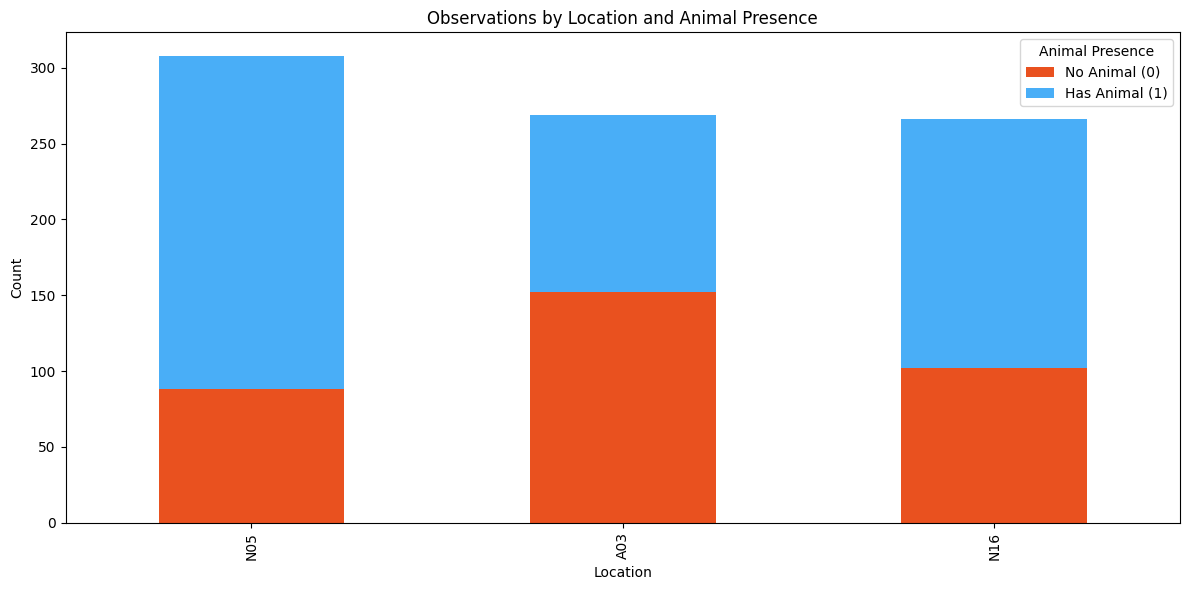

In [90]:
df_pivot.plot(kind='bar', stacked=True, color=["#E9511F", "#49AEF7"], figsize=(12, 6))
# Customize
plt.title("Observations by Location and Animal Presence")
plt.xlabel("Location")
plt.ylabel("Count")
plt.legend(["No Animal (0)", "Has Animal (1)"], title="Animal Presence")
plt.tight_layout()
plt.show()

In [91]:
df=df.drop("species", axis=1)

In [92]:
#plot_n_images(df,800)

In [93]:
image_data = []
labels = []
# Replace with your own dataframe or image/label loading logic
for i in range(len(df)):
    if(i%1000==0):
        print(i)
    img_path = f"Orinoquia_Carma_Traps/orinoquia_camera_traps_images/public/{df.file_name[i]}"
    img = Image.open(img_path).convert("L")  # Convert to grayscale for simplicity
    img_resized = img.resize((150, 150))       # Resize for consistency
    img_array = np.array(img_resized).flatten()  # Flatten to 1D vector
    image_data.append(img_array)
    labels.append(df.has_animal[i])

X = np.array(image_data)
y = np.array(labels)

0


## PCP

In [94]:
from pcp import PCP

In [95]:
X_rank = np.linalg.matrix_rank(X)
print(X_rank)

843


In [96]:
pcp_alm = PCP()
mu = pcp_alm.default_mu(X)

In [97]:
L_pcp, S_pcp = pcp_alm.decompose(X, mu, tol=1e-5, max_iter=500)

In [98]:
f'intrisic rank: {np.linalg.matrix_rank(L_pcp)}, original rank: {np.linalg.matrix_rank(X)}, fraction of outliers: {(S_pcp != 0).mean():.3f}'

'intrisic rank: 363, original rank: 843, fraction of outliers: 0.682'

0


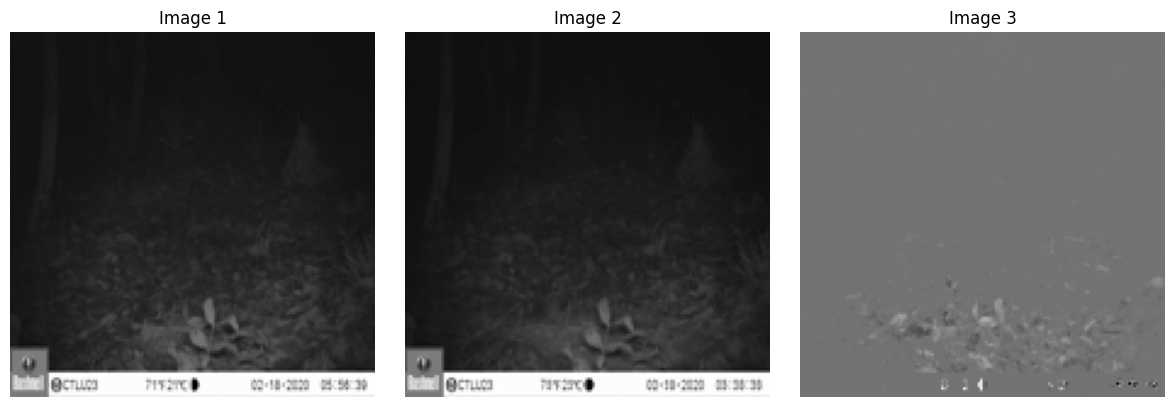

1


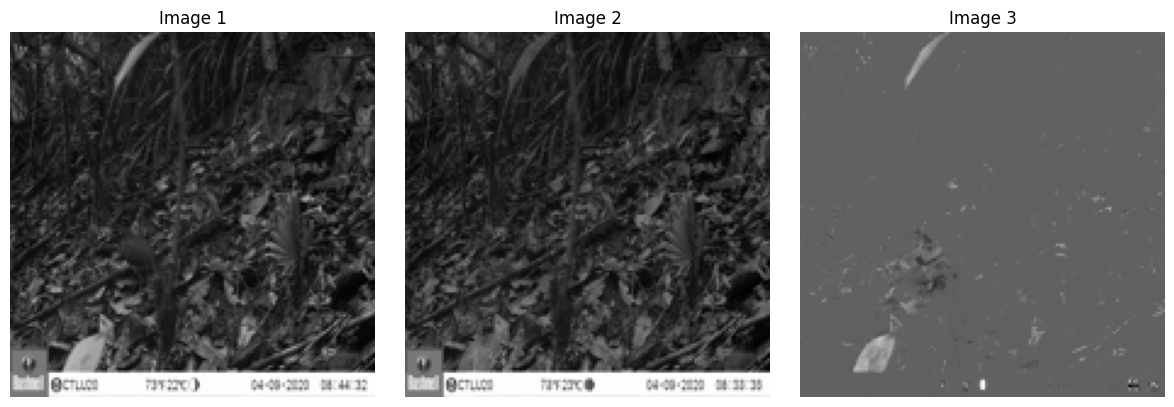

0


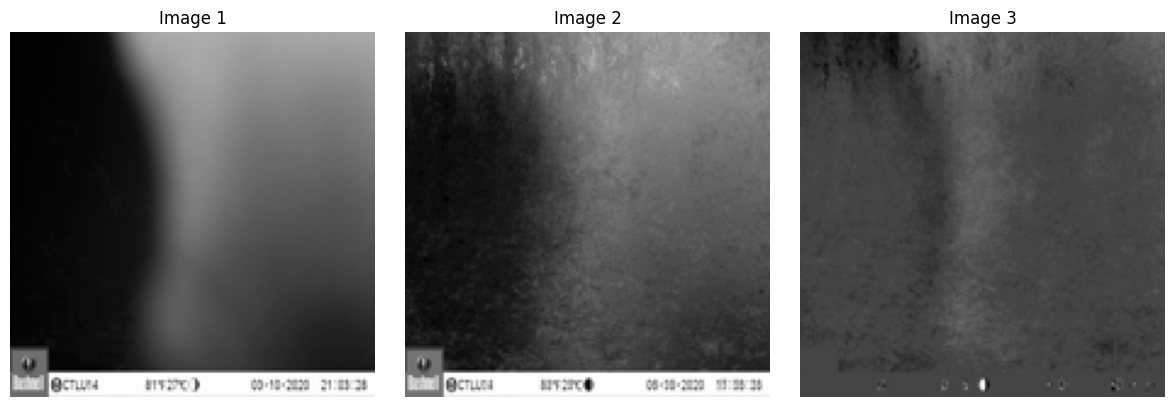

1


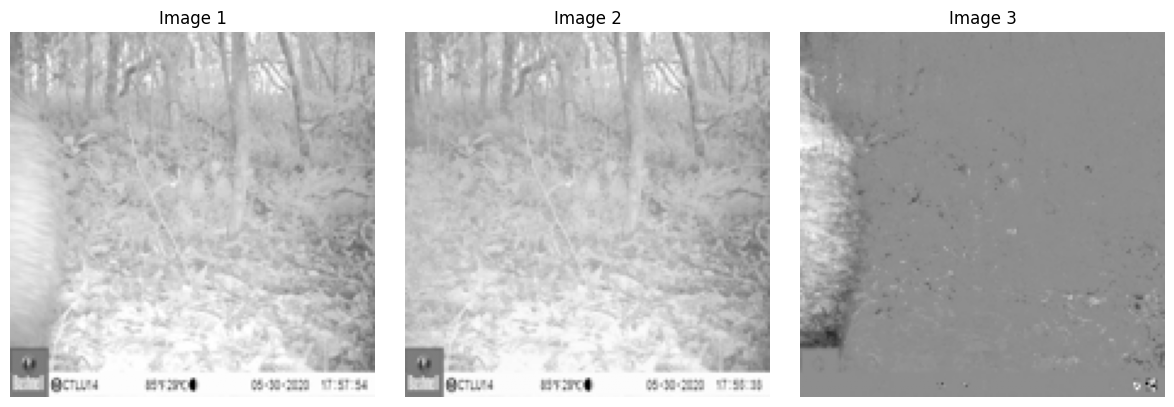

1


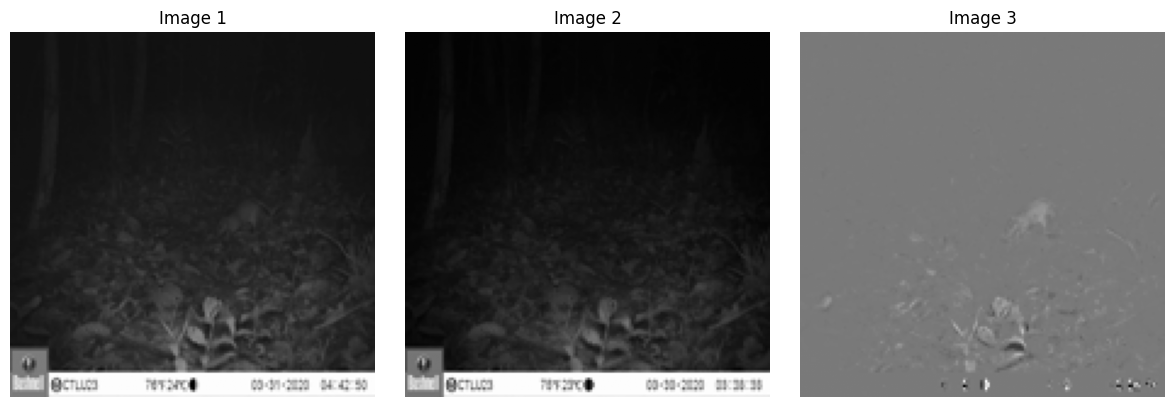

In [99]:
for i in range(0,5):
    index=i
    img_vector = X[index].reshape(1, -1)
    img_X=img_vector.reshape(150, 150)
    
    img_vector = L_pcp[index].reshape(1, -1)
    img_L=img_vector.reshape(150, 150)
    
    img_vector = S_pcp[index].reshape(1, -1)
    img_S=img_vector.reshape(150, 150)
    
    
    print(df.has_animal[i])
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))  # 1 row, 3 columns
    
    axs[0].imshow(img_X, cmap='gray')
    axs[0].set_title('Image 1')
    axs[0].axis('off')
    
    axs[1].imshow(img_L, cmap='gray')
    axs[1].set_title('Image 2')
    axs[1].axis('off')
    
    axs[2].imshow(img_S, cmap='gray')
    axs[2].set_title('Image 3')
    axs[2].axis('off')
    
    plt.tight_layout()
    plt.show()

In [100]:
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

state=109
# Split dataset into training set and test set


### Lin SVC  on S from PCP

In [101]:
X_train, X_test, y_train, y_test = train_test_split(S_pcp, y, test_size=0.3,random_state=state) # 70% training and 30% test

In [102]:
clf=LinearSVC()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

E:\camra trap identification\venv\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [103]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("F1:",metrics.f1_score(y_test, y_pred))
print("AUC:", metrics.roc_auc_score(y_test,y_pred))
print(clf.get_params())

Accuracy: 0.6521739130434783
F1: 0.6691729323308271
AUC: 0.66121165447311
{'C': 1.0, 'class_weight': None, 'dual': 'auto', 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'squared_hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': None, 'tol': 0.0001, 'verbose': 0}


## SVC GridSearch on S from PCP

In [104]:
X_train, X_test, y_train, y_test = train_test_split(S_pcp, y, test_size=0.3,random_state=state) # 70% training and 30% test

In [105]:
param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]

In [106]:
SVC=svm.SVC()
clf = GridSearchCV(SVC, param_grid, verbose=2)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END .................................C=1, kernel=linear; total time=  14.2s
[CV] END .................................C=1, kernel=linear; total time=  15.2s
[CV] END .................................C=1, kernel=linear; total time=  14.8s
[CV] END .................................C=1, kernel=linear; total time=  15.0s
[CV] END .................................C=1, kernel=linear; total time=  15.4s
[CV] END ................................C=10, kernel=linear; total time=  14.9s
[CV] END ................................C=10, kernel=linear; total time=  15.1s
[CV] END ................................C=10, kernel=linear; total time=  14.6s
[CV] END ................................C=10, kernel=linear; total time=  14.3s
[CV] END ................................C=10, kernel=linear; total time=  15.8s
[CV] END ...............................C=100, kernel=linear; total time=  14.4s
[CV] END ...............................C=100, k

In [107]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("F1:",metrics.f1_score(y_test, y_pred))
print("AUC:", metrics.roc_auc_score(y_test,y_pred))
print("Best parameters found:", clf.best_params_)

Accuracy: 0.6324110671936759
F1: 0.6436781609195402
AUC: 0.6442048517520216
Best parameters found: {'C': 1, 'kernel': 'linear'}


In [108]:
from sklearn.metrics import confusion_matrix
    
cm = confusion_matrix(y_test, y_pred)

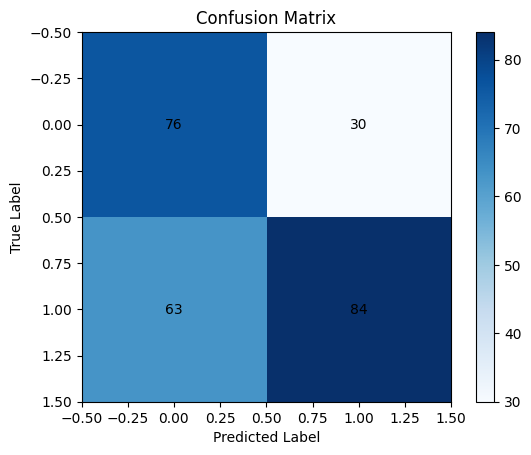

In [109]:

cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
    
for i in range(len(cm)):
    for j in range(len(cm)):
        plt.text(j, i, str(cm[i][j]), ha='center', va='center')
    
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## RF GridSearch on S from PCP

In [110]:
X_train, X_test, y_train, y_test = train_test_split(S_pcp, y, test_size=0.3,random_state=state) # 70% training and 30% test

In [111]:
from sklearn.ensemble import RandomForestClassifier
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

accuracy = best_model.score(X_test, y_test)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.3s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.5s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.8s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   3.4s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   3.5s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   4.0s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   9.0s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   7.4s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   7.5s
[CV] END max_depth=5, min_samples_leaf

In [112]:
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
accuracy = best_model.score(X_test, y_test)
y_pred = best_model.predict(X_test)
print(accuracy)

0.7905138339920948


In [113]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("F1:",metrics.f1_score(y_test, y_pred))
print("AUC:", metrics.roc_auc_score(y_test,y_pred))
print(best_params)

Accuracy: 0.7905138339920948
F1: 0.8379204892966361
AUC: 0.7631562058785778
{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}


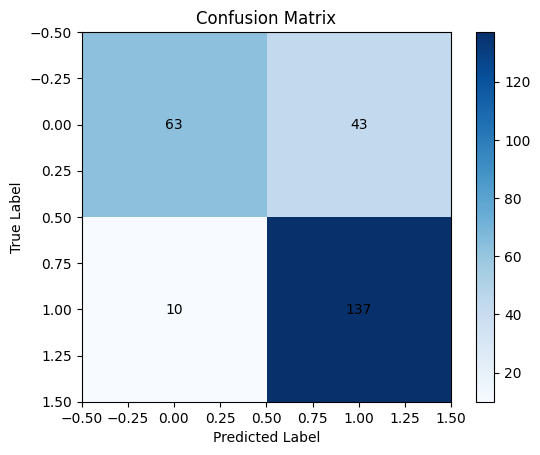

In [114]:

cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
    
for i in range(len(cm)):
    for j in range(len(cm)):
        plt.text(j, i, str(cm[i][j]), ha='center', va='center')
    
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#### Test this model on A03

In [115]:
# df=pd.read_csv("A03_balanced.csv")
# df=df.drop("species", axis=1)
# image_data = []
# labels = []
# # Replace with your own dataframe or image/label loading logic
# for i in range(len(df)):
#     if(i%1000==0):
#         print(i)
#     img_path = f"Orinoquia_Carma_Traps/orinoquia_camera_traps_images/public/{df.file_name[i]}"
#     img = Image.open(img_path).convert("L")  # Convert to grayscale for simplicity
#     img_resized = img.resize((150, 150))       # Resize for consistency
#     img_array = np.array(img_resized).flatten()  # Flatten to 1D vector
#     image_data.append(img_array)
#     labels.append(df.has_animal[i])

# X = np.array(image_data)
# y = np.array(labels)

In [116]:
# pcp_alm = PCP()
# mu = pcp_alm.default_mu(X)
# L_pcp, S_pcp = pcp_alm.decompose(X, mu, tol=1e-5, max_iter=500)

In [117]:
# accuracy = best_model.score(S_pcp, y)
# print(accuracy)

In [118]:
# y_pred = best_model.predict(X_test)
# cm = confusion_matrix(y_test, y_pred)
# plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
# plt.title('Confusion Matrix')
# plt.colorbar()
    
# for i in range(len(cm)):
#     for j in range(len(cm)):
#         plt.text(j, i, str(cm[i][j]), ha='center', va='center')
    
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.show()

## Lin SVC on S from stable PCP

In [119]:
# X_train, X_test, y_train, y_test = train_test_split(S_st_pcp, y, test_size=0.3,random_state=19) # 70% training and 30% test

In [120]:
# clf=LinearSVC()
# clf.fit(X_train, y_train)
# y_pred = clf.predict(X_test)

In [121]:
#print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

## SVC GridSearch on S from stable PCP

In [122]:
#X_train, X_test, y_train, y_test = train_test_split(S_pcp, y, test_size=0.3,random_state=109) # 70% training and 30% test

In [123]:
# param_grid = [
#   {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
#   {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
#  ]

In [124]:
# SVC=svm.SVC()
# clf = GridSearchCV(SVC, param_grid, verbose=2)
# clf.fit(X_train, y_train)
# y_pred = clf.predict(X_test)

In [125]:
#print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

In [126]:
# from sklearn.metrics import confusion_matrix
    
# cm = confusion_matrix(y_test, y_pred)

In [127]:
# import matplotlib.pyplot as plt
    
# plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
# plt.title('Confusion Matrix')
# plt.colorbar()
    
# for i in range(len(cm)):
#     for j in range(len(cm)):
#         plt.text(j, i, str(cm[i][j]), ha='center', va='center')
    
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.show()

## LinearSVC on images

In [128]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=state) # 70% training and 30% test

clf = LinearSVC()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

E:\camra trap identification\venv\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [129]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("F1:",metrics.f1_score(y_test, y_pred))
print("AUC:", metrics.roc_auc_score(y_test,y_pred))

Accuracy: 0.6640316205533597
F1: 0.6743295019157088
AUC: 0.6766782184571942


In [130]:
from sklearn.metrics import confusion_matrix
    
cm = confusion_matrix(y_test, y_pred)

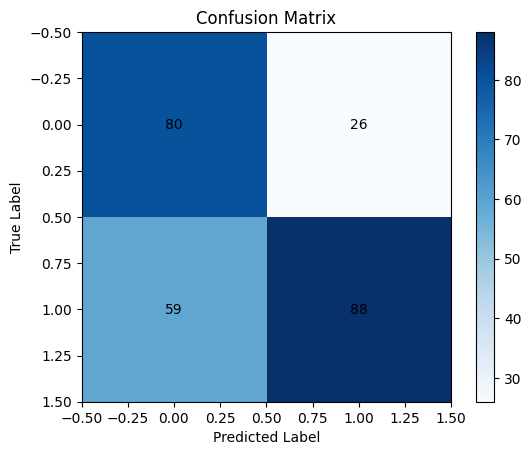

In [131]:
import matplotlib.pyplot as plt
    
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
    
for i in range(len(cm)):
    for j in range(len(cm)):
        plt.text(j, i, str(cm[i][j]), ha='center', va='center')
    
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## SVM gridsearch on image

In [132]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=state) # 70% training and 30% test

In [133]:
param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]

In [134]:
SVC=svm.SVC()
clf = GridSearchCV(SVC, param_grid, verbose=2)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END .................................C=1, kernel=linear; total time=  15.8s
[CV] END .................................C=1, kernel=linear; total time=  16.3s
[CV] END .................................C=1, kernel=linear; total time=  13.2s
[CV] END .................................C=1, kernel=linear; total time=  13.6s
[CV] END .................................C=1, kernel=linear; total time=  16.4s
[CV] END ................................C=10, kernel=linear; total time=  15.7s
[CV] END ................................C=10, kernel=linear; total time=  16.1s
[CV] END ................................C=10, kernel=linear; total time=  13.1s
[CV] END ................................C=10, kernel=linear; total time=  13.6s
[CV] END ................................C=10, kernel=linear; total time=  16.3s
[CV] END ...............................C=100, kernel=linear; total time=  15.7s
[CV] END ...............................C=100, k

In [135]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("F1:",metrics.f1_score(y_test, y_pred))
print("AUC:", metrics.roc_auc_score(y_test,y_pred))
print("Best parameters found:", clf.best_params_)

Accuracy: 0.6284584980237155
F1: 0.6492537313432836
AUC: 0.6355410088563729
Best parameters found: {'C': 1, 'kernel': 'linear'}


In [136]:
from sklearn.metrics import confusion_matrix
    
cm = confusion_matrix(y_test, y_pred)

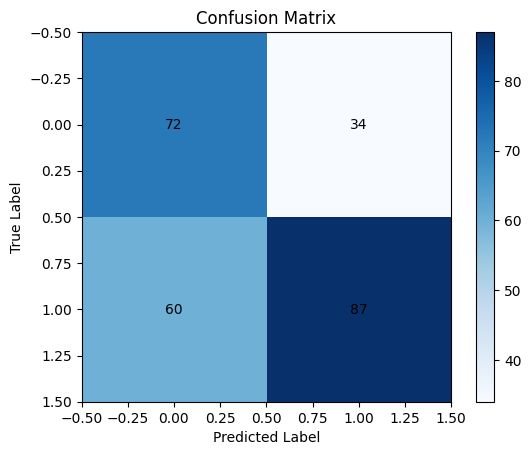

In [137]:
import matplotlib.pyplot as plt
    
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
    
for i in range(len(cm)):
    for j in range(len(cm)):
        plt.text(j, i, str(cm[i][j]), ha='center', va='center')
    
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## RF GridSearch on images

In [138]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=state) # 70% training and 30% test

In [139]:
from sklearn.ensemble import RandomForestClassifier
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

accuracy = best_model.score(X_test, y_test)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.2s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.3s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.2s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.5s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.6s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.6s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   6.4s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   6.5s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   6.6s
[CV] END max_depth=5, min_samples_leaf

In [140]:
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

accuracy = best_model.score(X_test, y_test)

print(accuracy)

0.7391304347826086


In [141]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("F1:",metrics.f1_score(y_test, y_pred))
print("AUC:", metrics.roc_auc_score(y_test,y_pred))
print(best_params)

Accuracy: 0.7391304347826086
F1: 0.7898089171974523
AUC: 0.7189385188037479
{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}


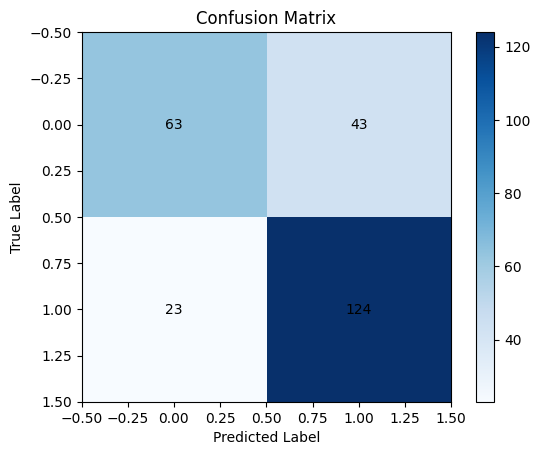

In [142]:
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
    
for i in range(len(cm)):
    for j in range(len(cm)):
        plt.text(j, i, str(cm[i][j]), ha='center', va='center')
    
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()